In [1]:
# Our stuff:
import casclik as cc
import casadi as cs
from urdf2casadi import converter, numpy_geom

# Plotting
from matplotlib import pyplot as plt
import common_plots
%matplotlib notebook

# UR5 Example
Note: This example requires access to urdf2casadi, a python module for converting urdf files and kinematic chains to casadi functions describing their forward kinematics. 

First, let's define the basic symbols and limits:

In [2]:
t = cs.MX.sym("t")
q = cs.MX.sym("q",6) # six actuated joints
dq = cs.MX.sym("dq",6)
max_speed = cs.np.pi/5 # rad/s
UR5_home = [0.0, -cs.np.pi/2, 0.0, -cs.np.pi/2, 0.0, 0.0]

## Get transformation matrix of forward kinematics
The converter creates a kinematic chain from a specific root link to an end link. Running `check_urdf` on the file, we find that the UR5 contains the links:
```
root Link: world has 1 child(ren)
    child(1):  base_link
        child(1):  base
        child(2):  shoulder_link
            child(1):  upper_arm_link
                child(1):  forearm_link
                    child(1):  wrist_1_link
                        child(1):  wrist_2_link
                            child(1):  wrist_3_link
                                child(1):  ee_link
                                child(2):  tool0
```

In [3]:
urdf_path = "./urdf/ur5.urdf"
links = ["world", 
         "base_link", 
         "shoulder_link", 
         "upper_arm_link", 
         "forearm_link", 
         "wrist_1_link", 
         "wrist_2_link", 
         "wrist_3_link", 
         "tool0"]
fk_dict = converter.from_file(root="base_link", tip="tool0", filename=urdf_path)

In [4]:
# Setup the function for the forward kinematics:
T_fk = fk_dict["T_fk"]

# Test transformation matrix:
T0 = T_fk(UR5_home)
print("Distance to UR5Home pos: "+str(cs.norm_2(T0[:3,3])))

Distance to UR5Home pos: 1.0192


In [5]:
# Check the joint limits from the URDF:
q_max = cs.np.array(fk_dict["upper"])
q_min = cs.np.array(fk_dict["lower"])
print("q_min ",str(q_min))
print("q_max ",str(q_max))

('q_min ', '[-6.28318531 -6.28318531 -3.14159265 -6.28318531 -6.28318531 -6.28318531]')
('q_max ', '[ 6.28318531  6.28318531  3.14159265  6.28318531  6.28318531  6.28318531]')


## Move to point skill

In [6]:
# Move to desired point
p_des = cs.np.array([0.5,
                     0.5,
                     0.5])

p_fk = T_fk(q)[:3,3]

p_err = p_des - p_fk

min_dist_cnstr = cc.EqualityConstraint(
    label="Minimize_point_error",
    expression=p_err,
    gain=50.,
    constraint_type="soft")

# Uphold the joint constraints
joint_limits_cnstr = cc.SetConstraint(
    label="Joint_Limits",
    expression = q,
    set_min = q_min,
    set_max = q_max)

# Let's have some speed limit
joint_speed_limits_cnstr = cc.VelocitySetConstraint(
    label="Joint_speed_limits",
    expression = q,
    set_min = -cs.vertcat([max_speed]*q.size()[0]),
    set_max = cs.vertcat([max_speed]*q.size()[0]))

In [7]:
# Define the skill
point_skill = cc.SkillSpecification(
    label="Move to point",
    time_var = t,
    robot_var = q,
    robot_vel_var = dq,
    constraints = [min_dist_cnstr,
                   joint_limits_cnstr,
                   joint_speed_limits_cnstr])

In [8]:
point_skill.print_constraints()

SkillSpecification: Move to point
#0: Minimize_point_error
#1: Joint_Limits
#2: Joint_speed_limits
Has virtual var: False
Has input var: False
N constraints: 3
N equality:
	Pos:1	Vel:0
N set:
	Pos:1	Vel:1


### QP

In [9]:
# Define the controller
qpcntrllr = cc.ReactiveQPController(
    skill_spec = point_skill)
qpcntrllr.setup_problem_functions()
qpcntrllr.setup_solver()

In [10]:
%%timeit # Let's check the timing with a random point in the range
test_initial = 0.5*cs.np.pi*cs.vertcat(cs.np.random.rand(q.size()[0])) + 0.25*cs.np.pi
qpcntrllr.solve(time_var=0.0, robot_var=test_initial)

The slowest run took 4.39 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 323 µs per loop


In [11]:
# Simulate it!
dt = 0.01
t_sim = cs.np.array([dt*i for i in xrange(1000)])
# Robot
q_sim = cs.np.zeros((len(t_sim),q.shape[0]))
q_sim[0,:] = UR5_home
dq_sim = cs.np.zeros((len(t_sim),dq.shape[0]))
# Cartesian
p_sim = cs.np.zeros((len(t_sim), 3))
p_sim[0,:] = T_fk(UR5_home)[:3,3].toarray()[:,0]
# Rotation
R_sim = cs.np.zeros((len(t_sim),3,3))
R_sim[0,:,:] = T_fk(UR5_home)[:3,:3].toarray()
# Loop
for i in xrange(len(t_sim) - 1):
    dq_sim[i,:] = qpcntrllr.solve(t_sim[i], q_sim[i,:])[0].toarray()[:,0]
    q_sim[i+1,:] = q_sim[i,:] + dq_sim[i,:]*dt
    p_sim[i+1,:] = T_fk(q_sim[i+1,:])[:3,3].toarray()[:,0]
    R_sim[i+1,:] = T_fk(q_sim[i+1,:])[:3,:3].toarray()

In [12]:
# Let's package results for easier comparison of the controllers:
sim_point_qp = {"t_sim": t_sim,
                "dq_sim": dq_sim,
                "q_sim": q_sim,
                "p_sim": p_sim,
                "R_sim": R_sim}

### Look at frame in 3D
In the following graphs, the black line is the position of the `tool0` frame. The red, green, and blue lines depict a point 10 cm from the origin of the `tool0` frame in $x$, $y$, and $z$ directions respectively. The final dots depict the desired end-pose/frame. As we're not concerned with the orientation, the red, green, and blue dots do not show up here.

(-1, 1)

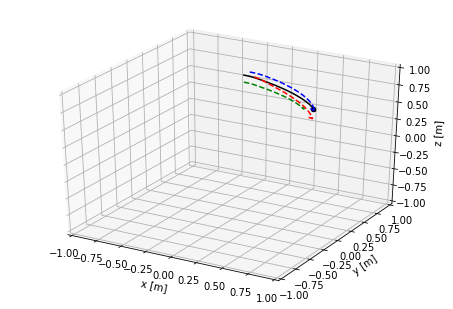

In [13]:
ax = common_plots.frame_3d(sim_point_qp,p_des=p_des)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])

### MPC

In [14]:
# Define the controller
mpcntrllr = cc.ModelPredictiveController(
    skill_spec = point_skill,
    cost_expr=cs.mtimes(dq.T,dq),
    horizon_length=5) # Same as QP
mpcntrllr.setup_problem_functions()
mpcntrllr.setup_solver()

In [15]:
%%timeit # Let's check the timing with a random point in the range
test_initial = 0.5*cs.np.pi*cs.vertcat(cs.np.random.rand(q.size()[0])) + 0.25*cs.np.pi
mpcntrllr.solve(time_var=0.0, robot_var=test_initial)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

100 loops, best of 3: 14.5 ms per loop


In [16]:
# Simulate it!
dt = 0.01
t_sim = cs.np.array([dt*i for i in xrange(1000)])
# Robot
q_sim = cs.np.zeros((len(t_sim),q.shape[0]))
q_sim[0,:] = UR5_home
dq_sim = cs.np.zeros((len(t_sim),dq.shape[0]))
# Cartesian
p_sim = cs.np.zeros((len(t_sim), 3))
p_sim[0,:] = T_fk(UR5_home)[:3,3].toarray()[:,0]
# Rotation
R_sim = cs.np.zeros((len(t_sim),3,3))
R_sim[0,:,:] = T_fk(UR5_home)[:3,:3].toarray()
# Loop
for i in xrange(len(t_sim) - 1):
    dq_sim[i,:] = mpcntrllr.solve(t_sim[i], q_sim[i,:])[0].toarray()[:,0]
    q_sim[i+1,:] = q_sim[i,:] + dq_sim[i,:]*dt
    p_sim[i+1,:] = T_fk(q_sim[i+1,:])[:3,3].toarray()[:,0]
    R_sim[i+1,:] = T_fk(q_sim[i+1,:])[:3,:3].toarray()

In [17]:
# Let's package results for easier comparison of the controllers:
sim_point_mp = {"t_sim": t_sim,
                "dq_sim": dq_sim,
                "q_sim": q_sim,
                "p_sim": p_sim,
                "R_sim": R_sim}

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3fdb4492d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f3fd9b85550>], dtype=object)

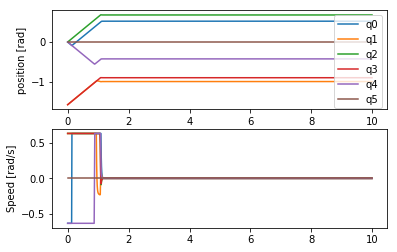

In [18]:
common_plots.joints(sim_point_mp)

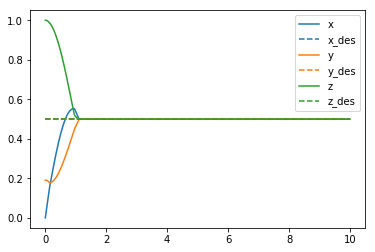

In [19]:
common_plots.pos_point(sim_point_mp, p_des=p_des)

(-1, 1)

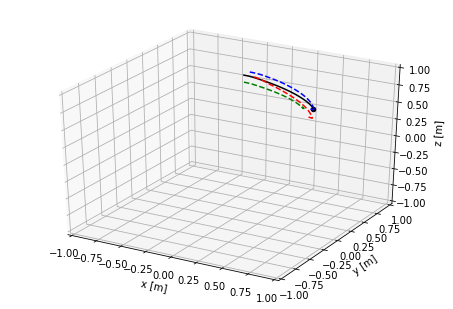

In [20]:
ax = common_plots.frame_3d(sim_point_mp, p_des=p_des)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])

### Pseudo inverse
An aspect of the implemented pseudoinversecontroller is that it does not currently handle SetConstraints that are vectors (also called multidimensional in the source code). There is experimental support that we can use by setting "multidim_sets" to True in options when setting up the controller, but we will not use that here. Instead we split the multidimensional constraint into multiple 1D constraints.

In [21]:
# Listify the joint limits constraints, starting with the lowest
joint_limits_cnstr_list = []
for i in range(q.size()[0]):
    joint_limits_cnstr_list.append(
    cc.SetConstraint(label="limit_q_"+str(i),
                     expression=q[i],
                     set_min = q_min[i],
                     set_max = q_max[i],
                    priority = i))
# Make the distance constraint the least prioritized
min_dist_cnstr.priority=i+1
min_dist_cnstr.expression = cs.norm_2(p_des - p_fk)
# redefine the skill
point_skill_pinv = cc.SkillSpecification(
    label="point_skill_pinv", 
    time_var = t, 
    robot_var = q, 
    robot_vel_var = dq, 
    constraints=[min_dist_cnstr]+ joint_limits_cnstr_list)
# Define the controller
pinvcntrllr = cc.PseudoInverseController(skill_spec=point_skill_pinv)
pinvcntrllr.setup_problem_functions()
pinvcntrllr.setup_solver()

In [22]:
%%timeit # Let's check the timing with a random point in the range
test_initial = 0.5*cs.np.pi*cs.vertcat(cs.np.random.rand(q.size()[0])) + 0.25*cs.np.pi
pinvcntrllr.solve(time_var=0.0, robot_var=test_initial)

1000 loops, best of 3: 199 µs per loop


In [23]:
# Simulate it!
dt = 0.01
t_sim = cs.np.array([dt*i for i in xrange(1000)])
# Robot
q_sim = cs.np.zeros((len(t_sim),q.shape[0]))
q_sim[0,:] = UR5_home
dq_sim = cs.np.zeros((len(t_sim),dq.shape[0]))
# Cartesian
p_sim = cs.np.zeros((len(t_sim), 3))
p_sim[0,:] = T_fk(UR5_home)[:3,3].toarray()[:,0]
# Rotation
R_sim = cs.np.zeros((len(t_sim), 3, 3))
R_sim[0,:,:] = T_fk(UR5_home)[:3,:3].toarray()
# Loop
for i in xrange(len(t_sim) - 1):
    dq_sim[i,:] = pinvcntrllr.solve(t_sim[i], q_sim[i,:])[0].toarray()[:,0]
    for idx, dqi in enumerate(dq_sim[i,:]):
        dq_sim[i,idx] = max(min(dqi,max_speed),-max_speed)
    q_sim[i+1,:] = q_sim[i,:] + dq_sim[i,:]*dt
    p_sim[i+1,:] = T_fk(q_sim[i+1,:])[:3,3].toarray()[:,0]
    R_sim[i+1,:,:] = T_fk(q_sim[i+1,:])[:3,:3].toarray()

In [24]:
# Let's package results for easier comparison of the controllers:
sim_point_pinv = {"t_sim": t_sim,
                  "dq_sim": dq_sim,
                  "q_sim": q_sim,
                  "p_sim":p_sim,
                 "R_sim":R_sim}

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3fd9120890>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f3fd0e5fb10>], dtype=object)

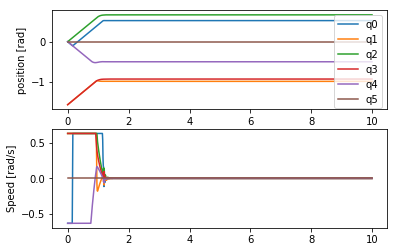

In [25]:
common_plots.joints(sim_point_pinv)

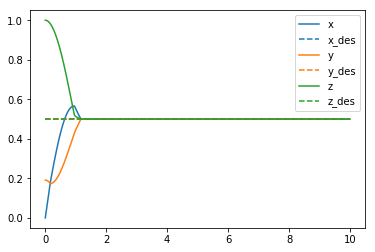

In [26]:
common_plots.pos_point(sim_point_pinv, p_des=p_des)

(-1, 1)

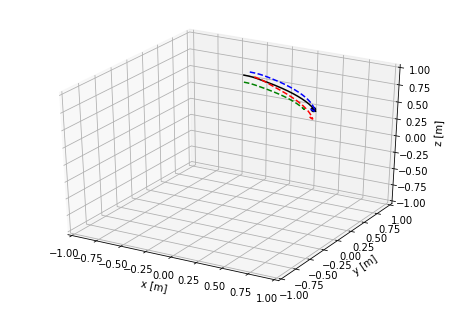

In [27]:
ax = common_plots.frame_3d(sim_point_pinv, p_des=p_des)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])

## Move to frame
In this example the frame attached to the end-effector is to match a reference frame. In this case we have many different choices of metrics to use. We can try to extract the Euler angles from the matrix and do euclidean distance on that, we can formulate quaternions and check the norm of the difference, we can look at deviation from identity matrix when doing inverse of the transformation rotation matrices, etc etc. 

We'll grab the `joint_speed_limits_cnstr` and `joint_limit_cnstr` from before.

And we will try out a few different ways of doing the orientation for the different controllers. The priority is set to a high number to guarantee that the firsst few priorities are the joint limits when using the pseudo inverse controllers.

In [28]:
roll = 0.0
pitch = cs.np.pi/2
yaw = 0.0
T_des = cs.np.eye(4) 
T_des[:3,:3] = numpy_geom.rotation_rpy(roll, pitch, yaw)
T_des[:3,3] = [0.5,0.5,0.5] # Some desired position 

In [29]:
# Full transformation distance to identity
transfmat_id_dist_cnstr = cc.EqualityConstraint(
    label="transfmat_id_dist",
    expression=cs.norm_fro(cs.mtimes(cs.inv(T_des),T_fk(q))-cs.np.eye(4)),
    gain=1.0,
    constraint_type="soft",
    priority=301
)
# Hack in a method of evaluating the constraint expression
transfmat_id_dist_cnstr.eval = cs.Function("f_transfmat_id_dist", [t,q],[transfmat_id_dist_cnstr.expression])

In [30]:
# Splitting position and orientation
pos_dist_cnstr = cc.EqualityConstraint(
    label="pos_dist",
    expression=T_fk(q)[:3,3]-T_des[:3,3],
    gain=0.1,
    constraint_type="soft",
    priority=301
)
# Hack in a method of evaluating the constraint expression
pos_dist_cnstr.eval = cs.Function("f_pos_dist", [t,q],[pos_dist_cnstr.expression])

# Rotation distance to identity matrix
rot_id_dist_cnstr = cc.EqualityConstraint(
    label="rot_id_dist",
    expression=cs.norm_fro(cs.mtimes(cs.inv(T_des[:3,:3]),T_fk(q)[:3,:3]) - cs.np.eye(3)),
    gain=1.0,
    constraint_type="soft",
    priority=300
)
# Hack in a method of evaluating the constraint expression
rot_id_dist_cnstr.eval = cs.Function("f_rot_id_dist", [t,q],[rot_id_dist_cnstr.expression])

# Frobenius norm of the difference of the matrices
rot_fro_dist_cnstr = cc.EqualityConstraint(
    label="rot_fro_dist",
    expression=cs.norm_fro(T_fk(q)[:3,:3] - T_des[:3,:3]),
    gain = 1.0,
    constraint_type="soft",
    priority=300
)
# Hack in a method of evaluating the constraint expression
rot_fro_dist_cnstr.eval = cs.Function("f_rot_fro_id_dist", [t,q],[rot_fro_dist_cnstr.expression])

# Position and orientation as one stacked constraint of equal priority (rot_id_dist)
rot_pos_stack_cnstr = cc.EqualityConstraint(
    label="rot_pos_stack",
    expression = cs.vertcat(T_fk(q)[:3,3]-T_des[:3,3], 
                            cs.norm_fro(cs.mtimes(cs.inv(T_des[:3,:3]),T_fk(q)[:3,:3]) - cs.np.eye(3))),
    gain = 1.0,
    constraint_type = "soft",
    priority = 300
)
# Hack in a method of evaluating the constraint expression
rot_pos_stack_cnstr.eval = cs.Function("f_rot_pos_stack", [t,q], [cs.norm_2(rot_pos_stack_cnstr.expression)])

In [31]:
# Let's test all the controllers
controller_classes = {
    "qp":cc.ReactiveQPController, 
    "nlp":cc.ReactiveNLPController, 
    "pinv":cc.PseudoInverseController, 
    "mpc":cc.ModelPredictiveController
}
controllers = {"qp":{},"nlp":{},"pinv":{},"mpc":{}}

In [32]:
# Setup all transfmat_dist_id controllers
for key in controllers.keys():
    if key != "pinv":
        constraints = [transfmat_id_dist_cnstr, joint_limits_cnstr, joint_speed_limits_cnstr]
    else:
        constraints = [transfmat_id_dist_cnstr] + joint_limits_cnstr_list
    skill_spec = cc.SkillSpecification(
        label="transfmat_dist",
        time_var=t, robot_var=q, robot_vel_var=dq,
        constraints=constraints)
    controllers[key]["transfmat_dist_id"] = controller_classes[key](skill_spec=skill_spec)
    controllers[key]["transfmat_dist_id"].setup_problem_functions()
    controllers[key]["transfmat_dist_id"].setup_solver()
    print("Completed "+str(key))

Completed qp
Completed pinv
Completed mpc
Completed nlp


In [33]:
# Setup all rot_id_dist controllers
for key in controllers.keys():
    if key != "pinv":
        constraints = [pos_dist_cnstr, rot_id_dist_cnstr, joint_limits_cnstr, joint_speed_limits_cnstr]
    else:
        constraints = [pos_dist_cnstr, rot_id_dist_cnstr] + joint_limits_cnstr_list
    skill_spec = cc.SkillSpecification(
        label="rot_dist",
        time_var=t, robot_var=q, robot_vel_var=dq,
        constraints=constraints)
    controllers[key]["rot_dist_id"] = controller_classes[key](skill_spec=skill_spec)
    controllers[key]["rot_dist_id"].setup_problem_functions()
    controllers[key]["rot_dist_id"].setup_solver()
    print("Completed "+str(key))

Completed qp
Completed pinv
Completed mpc
Completed nlp


In [34]:
# Setup all rot_fro_dist controllers
for key in controllers.keys():
    if key != "pinv":
        constraints = [pos_dist_cnstr, rot_fro_dist_cnstr, joint_limits_cnstr, joint_speed_limits_cnstr]
    else:
        constraints = [pos_dist_cnstr, rot_fro_dist_cnstr] + joint_limits_cnstr_list
    skill_spec = cc.SkillSpecification(
        label="rot_fro_dist",
        time_var=t, robot_var=q, robot_vel_var=dq,
        constraints=constraints)
    controllers[key]["rot_fro_dist"] = controller_classes[key](skill_spec=skill_spec)
    controllers[key]["rot_fro_dist"].setup_problem_functions()
    controllers[key]["rot_fro_dist"].setup_solver()
    print("Completed "+str(key))

Completed qp
Completed pinv
Completed mpc
Completed nlp


In [35]:
# Setup all rot_pos_stack controllers
for key in controllers.keys():
    if key != "pinv":
        constraints = [rot_pos_stack_cnstr, joint_limits_cnstr, joint_speed_limits_cnstr]
    else:
        constraints = [rot_pos_stack_cnstr] + joint_limits_cnstr_list
    skill_spec = cc.SkillSpecification(
        label="rot_pos_stack",
        time_var=t, robot_var=q, robot_vel_var=dq,
        constraints=constraints)
    controllers[key]["rot_pos_stack"] = controller_classes[key](skill_spec=skill_spec)
    controllers[key]["rot_pos_stack"].setup_problem_functions()
    controllers[key]["rot_pos_stack"].setup_solver()
    print("Completed "+str(key))

Completed qp
Completed pinv
Completed mpc
Completed nlp


In [ ]:
cnstr_situations={"transfmat_dist_id":transfmat_id_dist_cnstr, 
                  "rot_dist_id":rot_id_dist_cnstr,
                  "rot_fro_dist":rot_fro_dist_cnstr, 
                  "rot_pos_stack":rot_pos_stack_cnstr}

In [ ]:
dt = 0.01
timesteps = 6000
# Run all the simulations:
for cntr_key in controllers.keys():
    print("Controller:"+cntr_key)
    for cnstr_key in cnstr_situations.keys():
        print("\tCNSTR:"+str(cnstr_key))
        print("\t\tSetting up initial value problem")
        controllers[cntr_key][cnstr_key].setup_initial_problem_solver()
        print("\t\tSolving initial value problem")
        slack_res = controllers[cntr_key][cnstr_key].solve_initial_problem(0,UR5_home)[-1]
        print("\t\tSimulating:"+cnstr_key)
        # Simulate it!
        t_sim = cs.np.array([dt*i for i in xrange(timesteps+1)])
        # Robot
        q_sim = cs.np.zeros((len(t_sim),q.shape[0]))
        q_sim[0,:] = UR5_home
        dq_sim = cs.np.zeros((len(t_sim),dq.shape[0]))
        # Cartesian position
        p_sim = cs.np.zeros((len(t_sim), 3))
        p_sim[0,:] = T_fk(UR5_home)[:3,3].toarray()[:,0]
        # Rotation
        R_sim = cs.np.zeros((len(t_sim), 3, 3))
        R_sim[0,:,:] = T_fk(UR5_home)[:3,:3].toarray()
        # Error in Orientation
        e_sim = cs.np.zeros(len(t_sim))
        e_sim[0] = cnstr_situations[cnstr_key].eval(t_sim[0],q_sim[0,:])
        # Error position
        ep_sim = cs.np.zeros(len(t_sim))
        ep_sim[0] = cs.norm_2(pos_dist_cnstr.eval(t_sim[0], q_sim[0, :]))
        # Loop
        try:
            for i in range(len(t_sim) - 1):
                res = controllers[cntr_key][cnstr_key].solve(t_sim[i],q_sim[i,:],warmstart_slack_var=slack_res)
                dq_sim[i,:] = res[0].toarray()[:,0]
                if res[-1] is not None:
                    slack_res = res[-1].toarray()[:,0]
                for idx, dqi in enumerate(dq_sim[i,:]):
                    dq_sim[i,idx] = max(min(dqi,max_speed),-max_speed)
                q_sim[i+1,:] = q_sim[i,:] + dq_sim[i,:]*dt
                p_sim[i+1,:] = T_fk(q_sim[i+1,:])[:3,3].toarray()[:,0]
                R_sim[i+1,:,:] = T_fk(q_sim[i+1,:])[:3,:3].toarray()
                e_sim[i+1] = cnstr_situations[cnstr_key].eval(t_sim[i],q_sim[i+1,:])
                if pos_dist_cnstr in controllers[cntr_key][cnstr_key].skill_spec.constraints:
                    ep_sim[i+1] = cs.norm_2(pos_dist_cnstr.eval(t_sim[i+1], q_sim[i+1,:]))
        except:
            print("\tFAILED")
        controllers[cntr_key][str(cnstr_key)+"_res"] = {
            "t_sim":t_sim,
            "dq_sim": dq_sim,
            "q_sim": q_sim,
            "p_sim": p_sim,
            "R_sim": R_sim,
            "e_sim": e_sim,
            "ep_sim": ep_sim
        }

Controller:qp
	CNSTR:rot_fro_dist
		Setting up initial value problem
		Solving initial value problem
		Simulating:rot_fro_dist
	CNSTR:transfmat_dist_id
		Setting up initial value problem
		Solving initial value problem
		Simulating:transfmat_dist_id
	CNSTR:rot_pos_stack
		Setting up initial value problem
		Solving initial value problem
		Simulating:rot_pos_stack
	CNSTR:rot_dist_id
		Setting up initial value problem
		Solving initial value problem
		Simulating:rot_dist_id
Controller:pinv
	CNSTR:rot_fro_dist
		Setting up initial value problem
		Solving initial value problem
		Simulating:rot_fro_dist
	CNSTR:transfmat_dist_id
		Setting up initial value problem
		Solving initial value problem
		Simulating:transfmat_dist_id
	CNSTR:rot_pos_stack
		Setting up initial value problem
		Solving initial value problem
		Simulating:rot_pos_stack
	CNSTR:rot_dist_id
		Setting up initial value problem
		Solving initial value problem
		Simulating:rot_dist_id
Controller:mpc
	CNSTR:rot_fro_dist
		Setting u

### Inspecting the motions
The following section shows 3D plots of the motions of the UR5 with the different controllers and constraint formulations. The black line signifies the center of the end-effector, the red, green, and blue lines are 0.1 m away in x, y, and z direction respectively. The dots denote the desired frame position and orientation.

In [ ]:
ax = common_plots.frame_3d(controllers["qp"]["rot_dist_id_res"], T_des=T_des)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
plt.title("QP(rot_dist_id)")

In [ ]:
ax = common_plots.frame_3d(controllers["qp"]["rot_fro_dist_res"], T_des=T_des)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
plt.title("QP(rot_fro_dist)")

In [ ]:
ax = common_plots.frame_3d(controllers["qp"]["transfmat_dist_id_res"], T_des=T_des)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
plt.title("QP(transfmat_dist_id)")

In [ ]:
ax = common_plots.frame_3d(controllers["qp"]["rot_pos_stack_res"], T_des=T_des)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
plt.title("QP(rot_pos_stack)")

In [ ]:
ax = common_plots.frame_3d(controllers["nlp"]["rot_dist_id_res"], T_des=T_des)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
plt.title("NLP(rot_dist_id)")

In [ ]:
ax = common_plots.frame_3d(controllers["nlp"]["rot_fro_dist_res"], T_des=T_des)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
plt.title("NLP(rot_fro_dist)")

In [ ]:
ax = common_plots.frame_3d(controllers["nlp"]["transfmat_dist_id_res"], T_des=T_des)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
plt.title("NLP(transfmat_dist_id)")

In [ ]:
ax = common_plots.frame_3d(controllers["nlp"]["rot_pos_stack_res"], T_des=T_des)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
plt.title("NLP(rot_pos_stack)")

In [ ]:
ax = common_plots.frame_3d(controllers["mpc"]["rot_dist_id_res"], T_des=T_des)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
plt.title("MPC(rot_dist_id)")

In [ ]:
ax = common_plots.frame_3d(controllers["mpc"]["rot_fro_dist_res"], T_des=T_des)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
plt.title("MPC(rot_fro_dist)")

In [ ]:
ax = common_plots.frame_3d(controllers["mpc"]["transfmat_dist_id_res"], T_des=T_des)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
plt.title("MPC(transfmat_dist_id)")

In [ ]:
ax = common_plots.frame_3d(controllers["mpc"]["rot_pos_stack_res"], T_des=T_des)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
plt.title("MPC(rot_pos_stack)")

In [ ]:
ax = common_plots.frame_3d(controllers["pinv"]["rot_dist_id_res"], T_des=T_des)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
plt.title("PINV(rot_dist_id)")

In [ ]:
ax = common_plots.frame_3d(controllers["pinv"]["rot_fro_dist_res"], T_des=T_des)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
plt.title("PINV(rot_fro_dist)")

In [ ]:
ax = common_plots.frame_3d(controllers["pinv"]["transfmat_dist_id_res"], T_des=T_des)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
plt.title("PINV(transfmat_dist_id)")

In [ ]:
ax = common_plots.frame_3d(controllers["pinv"]["rot_pos_stack_res"], T_des=T_des)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])
plt.title("PINV(rot_pos_stack)")

All the controllers and formulations converge to the desired frame, but their convergence and motions differ. To gain more insight, let's inspect the errors.

### Inspecting the errors

In [ ]:
# Comparing controllers for rot_dist_id
cntrllr_names = controllers.keys()
fig, ax = plt.subplots()
for name in cntrllr_names:
    ax.plot(controllers[name]["rot_dist_id_res"]["t_sim"],
            controllers[name]["rot_dist_id_res"]["e_sim"], label=name)
    ax.plot(controllers[name]["rot_dist_id_res"]["t_sim"],
            controllers[name]["rot_dist_id_res"]["e_sim"]+controllers[name]["rot_dist_id_res"]["ep_sim"],
           label=name+"(+pos)",ls="--")
ax.set_title("rot_dist_id")
ax.set_yscale("log")
ax.legend()

In [ ]:
# Comparing controllers for rot_fro_dist
cntrllr_names = controllers.keys()
fig, ax = plt.subplots()
for name in cntrllr_names:
    ax.plot(controllers[name]["rot_fro_dist_res"]["t_sim"],
            controllers[name]["rot_fro_dist_res"]["e_sim"], label=name)
    ax.plot(controllers[name]["rot_fro_dist_res"]["t_sim"],
            controllers[name]["rot_fro_dist_res"]["e_sim"]+controllers[name]["rot_fro_dist_res"]["ep_sim"],
           label=name+"(+pos)",ls="--")
ax.set_title("rot_fro_dist")
ax.set_yscale("log")
ax.legend()

In [ ]:
# Comparing controllers for rot_fro_dist
cntrllr_names = controllers.keys()
fig, ax = plt.subplots()
for name in cntrllr_names:
    ax.plot(controllers[name]["transfmat_dist_id_res"]["t_sim"],
            controllers[name]["transfmat_dist_id_res"]["e_sim"], label=name)
    ax.set_title("transfmat_dist_id")
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("t [s]")

In [ ]:
# Comparing controllers for rot_fro_dist
cntrllr_names = controllers.keys()
fig, ax = plt.subplots()
for name in cntrllr_names:
    ax.plot(controllers[name]["rot_pos_stack_res"]["t_sim"],
            controllers[name]["rot_pos_stack_res"]["e_sim"], label=name)
    ax.set_title("rot_pos_stack")
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("t [s]")

### Discussion

In general it would seem that combining constraints is a good idea. Both `transfmat_dist_id` and `rot_pos_stack`appear to perform better than having rotation and position split from each other.

The different controllers exhibit different numerical limits and behavior. This may be possible to affect by changing the parameters in the underlying solvers for the controllers, for the time being we will just observe that in general NLP and MPC (which rely on IPOPT for solving the underlying optimization problem) perform better with `rot_pos_stack` than they do with `transfmat_dist_id`. This could be a result of how `transfmat_dist_id`, defined as:
$$
expr = ||{T}_{\text{des}}^{-1}{T}_{fk}({q}) -{I}_{4\times 4}||_F \in \mathbb{R}^1
$$
requires all the variables to be found through a Jacobian of dimensions $1\times n_{{q}}$. Whereas `rot_pos_stack`, defined as:
$$
expr = \begin{bmatrix}
{p}_{fk}({q}) - {p}_{\text{des}}\\
||{R}_{\text{des}}^{-1}{R}_{fk}({q}) - {I}_{3\times 3}||_F
\end{bmatrix}\in \mathbb{R}^4
$$
finds all the variables through a Jacobian of dimensions $4\times n_{{q}}$. 

In general we see that the `rot_pos_stack` approach appears to work better, and we suggest using this formulation when one wants to move to a specific pose. Tuning of gains and parameters, exploring orientations uniformly sampled throughout the state-space and potentially outside the state-space are left for future work.